Import libraries

In [2]:
import os,keras,cv2 #cv2 requiered for selective search on images
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

def iou function

In [3]:
def get_iou(bb1, bb2):
    assert bb1['x1'] < bb1['x2']
    assert bb1['y1'] < bb1['y2']
    assert bb2['x1'] < bb2['x2']
    assert bb2['y1'] < bb2['y2']

    x_left = max(bb1['x1'], bb2['x1'])
    y_top = max(bb1['y1'], bb2['y1'])
    x_right = min(bb1['x2'], bb2['x2'])
    y_bottom = min(bb1['y2'], bb2['y2'])

    if x_right < x_left or y_bottom < y_top:
        return 0.0

    intersection_area = (x_right - x_left) * (y_bottom - y_top)

    bb1_area = (bb1['x2'] - bb1['x1']) * (bb1['y2'] - bb1['y1'])
    bb2_area = (bb2['x2'] - bb2['x1']) * (bb2['y2'] - bb2['y1'])

    iou = intersection_area / float(bb1_area + bb2_area - intersection_area)
    assert iou >= 0.0
    assert iou <= 1.0
    return iou

create lists and start getting training samples both negative and positive

In [4]:
train_images=[]
train_labels=[]

paths = "/content/photos_test"
annot = "/content/anotaciones_test"

ss = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()

for e,i in enumerate(os.listdir(annot)):
    try:
        if i.startswith("tuberculosis"):
            filename=i.split(".")[0]+".jpg"
            image=cv2.imread(os.path.join(paths,filename))
            df=pd.read_csv(os.path.join(annot,i))
            gtvalues=[]
            for row in df.iterrows():
                x1 = int(row[1][0].split(" ")[0])
                y1 = int(row[1][0].split(" ")[1])
                x2 = int(row[1][0].split(" ")[2])
                y2 = int(row[1][0].split(" ")[3])
                gtvalues.append({"x1":x1,"x2":x2,"y1":y1,"y2":y2})
            ss.setBaseImage(image)
            ss.switchToSelectiveSearchFast()
            ssresults = ss.process()
            imout = image.copy()
            counter = 0
            falsecounter = 0
            flag = 0
            fflag = 0
            bflag = 0
            for e,result in enumerate(ssresults):
                if e<2000 and flag ==0:
                    for gtval in gtvalues:
                        x,y,w,h = result
                        iou = get_iou(gtval,{"x1":x,"x2":x+w,"y1":y,"y2":y+h})
                        if counter < 30:
                            if iou > 0.70:
                                timage = imout[y:y+h,x:x+w]
                                resized = cv2.resize(timage, (224,224), interpolation = cv2.INTER_AREA)
                                train_images.append(resized)
                                train_labels.append(1)
                                counter += 1
                        else :
                            fflag =1
                        if falsecounter <30:
                            if iou < 0.3:
                                timage = imout[y:y+h,x:x+w]
                                resized = cv2.resize(timage, (224,224), interpolation = cv2.INTER_AREA)
                                train_images.append(resized)
                                train_labels.append(0)
                                falsecounter += 1
                        else :
                            bflag = 1
                    if fflag == 1 and bflag == 1:
                        print("inside")
                        flag = 1
    except Exception as e:
        print(e)
        print("error in "+filename)
        continue





Now we transform the object into a numpy array so we can work with it easily

In [5]:
X_new = np.array(train_images)
y_new = np.array(train_labels)

X_new.shape

(329, 224, 224, 3)

In [6]:
from keras.layers import Dense
from keras import Model
from keras import optimizers
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg16 import VGG16

vggmodel = VGG16(weights='imagenet', include_top=True)
vggmodel.summary()

553476096/553467096 [==============================] - 5s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                            

In [7]:
for layers in (vggmodel.layers)[:15]:
    print(layers)
    layers.trainable = False

In [8]:
X= vggmodel.layers[-2].output

In [9]:
predictions = Dense(2, activation="softmax")(X)

In [10]:
model_final = Model(vggmodel.input, predictions)

In [11]:
from tensorflow.keras.optimizers import Adam
opt = Adam(lr=0.0001)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [12]:
model_final.compile(loss = keras.losses.categorical_crossentropy, optimizer = opt, metrics=["accuracy"])

In [13]:
model_final.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [14]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer

In [15]:
class MyLabelBinarizer(LabelBinarizer):
    def transform(self, y):
        Y = super().transform(y)
        if self.y_type_ == 'binary':
            return np.hstack((Y, 1-Y))
        else:
            return Y
    def inverse_transform(self, Y, threshold=None):
        if self.y_type_ == 'binary':
            return super().inverse_transform(Y[:, 0], threshold)
        else:
            return super().inverse_transform(Y, threshold)

In [16]:
lenc = MyLabelBinarizer()
Y =  lenc.fit_transform(y_new)

In [17]:
X_train, X_test , y_train, y_test = train_test_split(X_new,Y,test_size=0.10)

In [18]:
print(X_train.shape,X_test.shape,y_train.shape,y_test.shape)

(296, 224, 224, 3) (33, 224, 224, 3) (296, 2) (33, 2)


In [19]:
trdata = ImageDataGenerator(horizontal_flip=True, vertical_flip=True, rotation_range=90)
traindata = trdata.flow(x=X_train, y=y_train)
tsdata = ImageDataGenerator(horizontal_flip=True, vertical_flip=True, rotation_range=90)
testdata = tsdata.flow(x=X_test, y=y_test)

In [20]:
from keras.callbacks import ModelCheckpoint, EarlyStopping

In [21]:
checkpoint = ModelCheckpoint("ieeercnn_vgg16_1.h5", monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', save_freq=1)
early = EarlyStopping(monitor='val_loss', min_delta=0, patience=100, verbose=1, mode='auto')

In [ ]:
hist = model_final.fit_generator(generator= traindata, steps_per_epoch= 10, epochs= 10, validation_data= testdata, validation_steps=2, callbacks=[checkpoint,early])

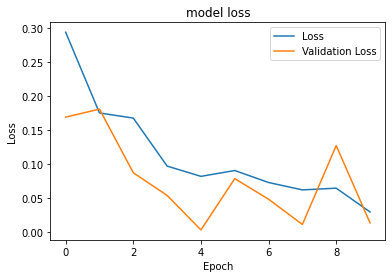

<Figure size 432x288 with 0 Axes>

In [24]:
import matplotlib.pyplot as plt
# plt.plot(hist.history["acc"])
# plt.plot(hist.history['val_acc'])
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title("model loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend(["Loss","Validation Loss"])
plt.show()
plt.savefig('chart loss.png')

not plane


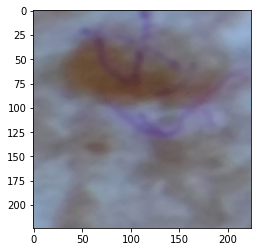

In [25]:
im = X_test[20]
plt.imshow(im)
img = np.expand_dims(im, axis=0)
out= model_final.predict(img)
if out[0][0] > out[0][1]:
    print("plane")
else:
    print("not plane")

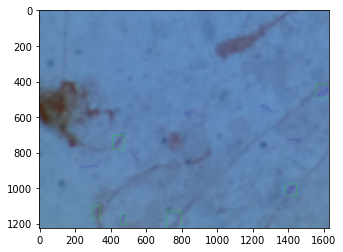

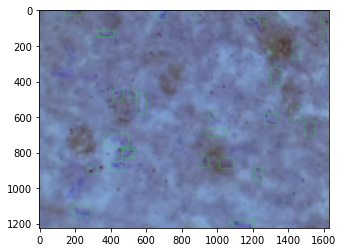

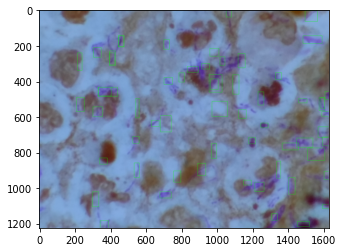

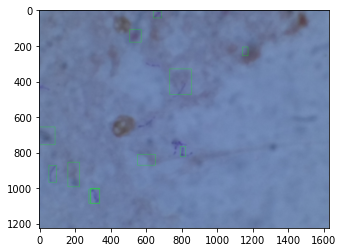

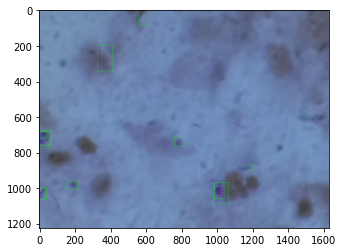

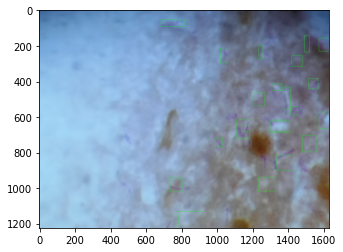

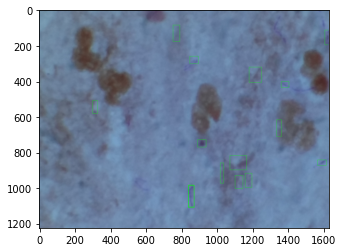

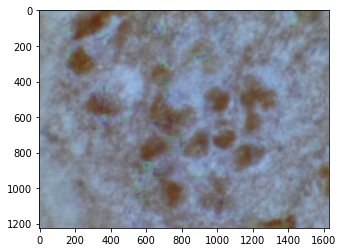

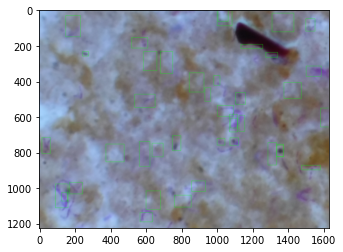

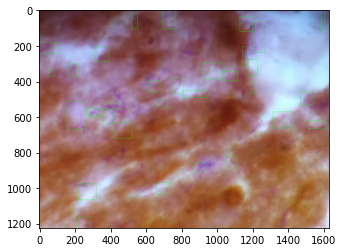

In [26]:
z=0
for e,i in enumerate(os.listdir(paths)):
    if i.startswith("tub"):
        z += 1
        img = cv2.imread(os.path.join(paths,i))
        ss.setBaseImage(img)
        ss.switchToSelectiveSearchFast()
        ssresults = ss.process()
        imout = img.copy()
        for e,result in enumerate(ssresults):
            if e < 2000:
                x,y,w,h = result
                timage = imout[y:y+h,x:x+w]
                resized = cv2.resize(timage, (224,224), interpolation = cv2.INTER_AREA)
                img = np.expand_dims(resized, axis=0)
                out= model_final.predict(img)
                if out[0][0] > 0.65:
                    cv2.rectangle(imout, (x, y), (x+w, y+h), (0, 255, 0), 1, cv2.LINE_AA)
        plt.figure()
        plt.imshow(imout)